From this notebook: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=dq9GY37ml1kr

There are some changes for running locally!

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch, detectron2

In [4]:
from matplotlib import pyplot as plt

In [5]:
plt.rcParams["figure.figsize"] = (60,10)

# reset to default
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [6]:
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [7]:
# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

In [8]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [9]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [10]:
torch.cuda.is_available()
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce GTX 1650'

## Custom dataset -> balloon

[Balloon segmentation dataset.](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon) -> has 1 class "balloon".

COCO dataset doesn't have "balloon" category!

In [ ]:
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip -q -O data/balloon_dataset.zip

/usr/bin/sh: 1: unzip: not found


In [19]:
!unzip data/balloon_dataset.zip > /dev/null

### Register in COCO format

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.

COCO data format: https://cocodataset.org/#format-data


In [11]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [12]:
balloon_metadata

namespace(name='balloon_train', thing_classes=['balloon'])

### Verify the dataset

To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:

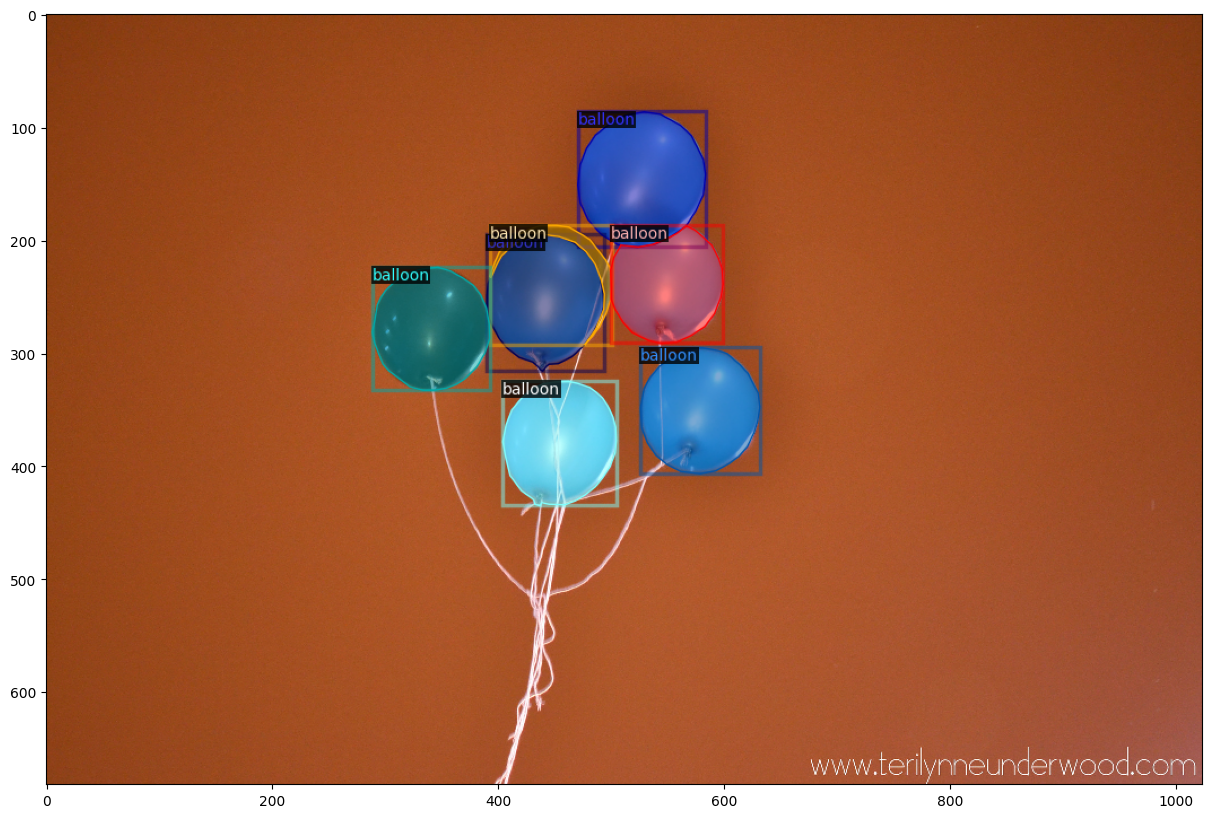

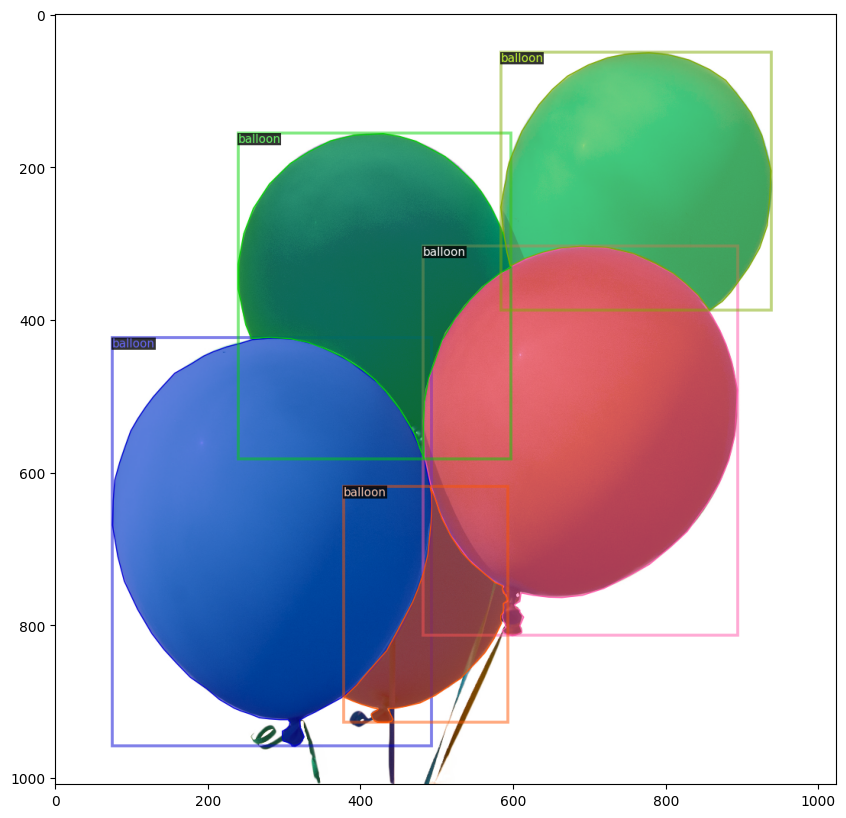

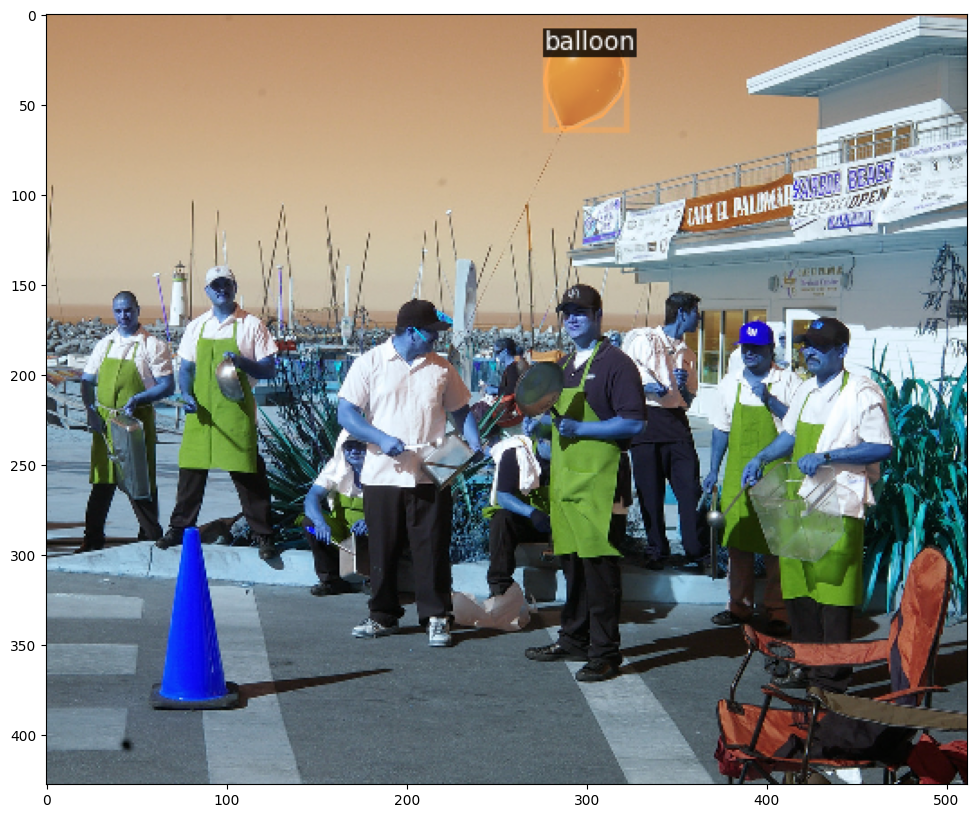

In [26]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # cv2_imshow(out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

### Train

[`DefaultTrainer` doc](https://detectron2.readthedocs.io/en/latest/modules/engine.html#detectron2.engine.defaults.DefaultTrainer).

In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16 # use 16 instead of 128 because "GPU out of memory"
# The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/02 08:26:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[09/02 08:26:41 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/02 08:26:49 d2.utils.events]:  eta: 0:01:42  iter: 19  total_loss: 2.085  loss_cls: 0.6828  loss_box_reg: 0.6964  loss_mask: 0.6934  loss_rpn_cls: 0.03207  loss_rpn_loc: 0.005274  time: 0.3606  data_time: 0.0057  lr: 1.6068e-05  max_mem: 1540M
[09/02 08:26:56 d2.utils.events]:  eta: 0:01:34  iter: 39  total_loss: 2.2  loss_cls: 0.5985  loss_box_reg: 0.977  loss_mask: 0.6156  loss_rpn_cls: 0.01344  loss_rpn_loc: 0.003024  time: 0.3568  data_time: 0.0017  lr: 3.2718e-05  max_mem: 1540M
[09/02 08:27:04 d2.utils.events]:  eta: 0:01:26  iter: 59  total_loss: 1.792  loss_cls: 0.4642  loss_box_reg: 0.8418  loss_mask: 0.4638  loss_rpn_cls: 0.01196  loss_rpn_loc: 0.003728  time: 0.3595  data_time: 0.0018  lr: 4.9367e-05  max_mem: 1540M
[09/02 08:27:11 d2.utils.events]:  eta: 0:01:20  iter: 79  total_loss: 1.579  loss_cls: 0.3586  loss_box_reg: 0.8335  loss_mask: 0.3532  loss_rpn_cls: 0.006098  loss_rpn_loc: 0.002896  time: 0.3631  data_time: 0.0019  lr: 6.6017e-05  max_mem: 1540M
[09/02 08:

### Save model

https://stackoverflow.com/questions/66037566/how-to-save-a-model-using-defaulttrainer-in-detectron2

[`detectron2.checkpoint`](https://detectron2.readthedocs.io/en/latest/modules/checkpoint.html?highlight=DetectionCheckpointer#detectron2.checkpoint.DetectionCheckpointer) (link)

In [19]:
from detectron2.checkpoint import Checkpointer

In [21]:
checkpointer = Checkpointer(trainer.model, save_dir="./saved_models/")
checkpointer.save("checkpointer_balloon")

### Check in Tensorboard

In [16]:
cfg.OUTPUT_DIR

'./output'

In [25]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6007 (pid 2610), started 0:00:21 ago. (Use '!kill 2610' to kill it.)

### Inference

In [26]:
cfg.OUTPUT_DIR

'./output'

In [27]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[09/02 13:44:16 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

Then, we randomly select several samples to visualize the prediction results.

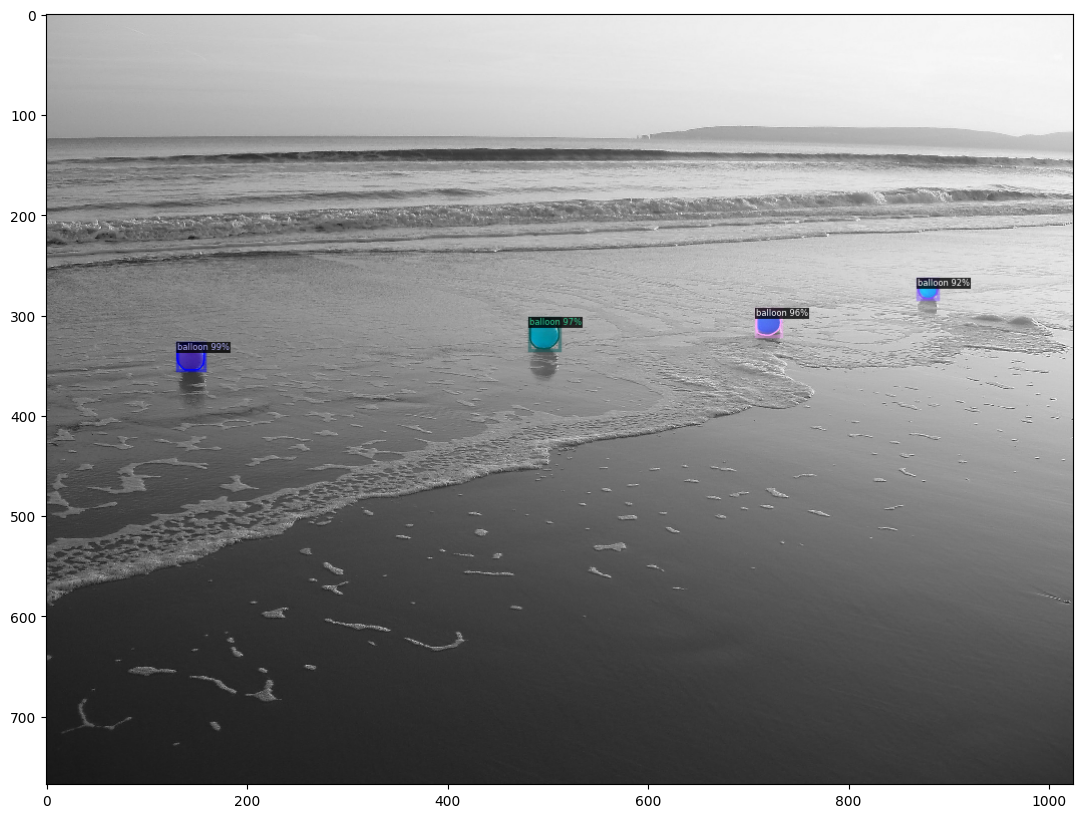

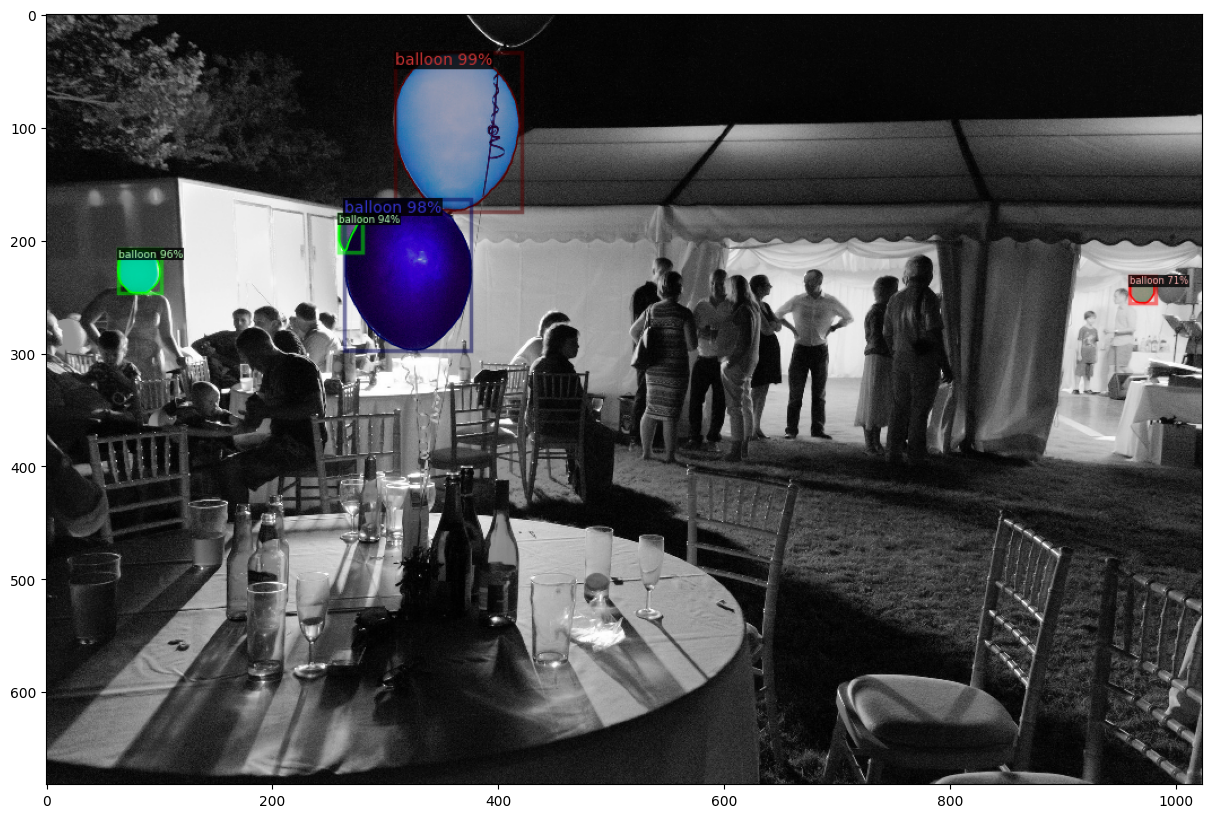

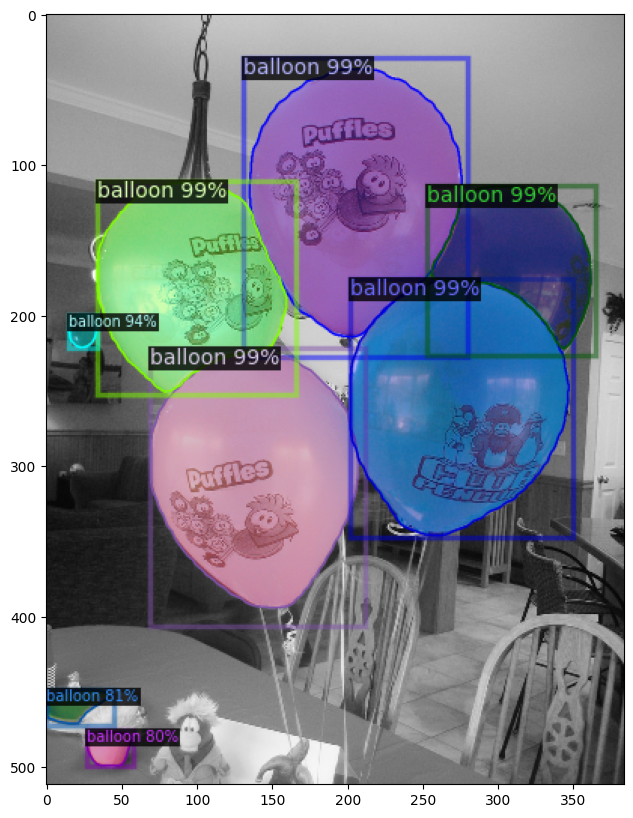

In [29]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

### COCO API's AP metric to evaluate

AP = "Average Precision" => mAP = mean average precision <= no distinction between them!

https://cocodataset.org/#detection-eval

In [31]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[09/02 15:25:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/02 15:25:12 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[09/02 15:25:12 d2.data.common]: Serialized dataset takes 0.04 MiB
[09/02 15:25:12 d2.evaluation.evaluator]: Start inference on 13 batches
[09/02 15:25:15 d2.evaluation.evaluator]: Inference done 11/13. Dataloading: 0.0007 s/iter. Inference: 0.2048 s/iter. Eval: 0.0041 s/iter. Total: 0.2096 s/iter. ETA=0:00:00
[09/02 15:25:15 d2.evaluation.evaluator]: Total inference time: 0:00:01.708279 (0.213535 s / iter per device, on 1 devices)
[09/02 15:25:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.203910 s / iter per device, on 1 devices)
[09/02 15:25:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/02 15:25:15 d2.evaluation.coco_evaluation]: Saving results to